In [91]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as NN
import torch.nn.functional as funct
import matplotlib.pyplot as plt
import torch.optim as optim
import pandas as pd
import numpy as np
import pickle

In [112]:
train = pickle.load(open("/content/drive/MyDrive/Data_Q4/train_CIFAR.pickle",'rb'))
test = pickle.load(open("/content/drive/MyDrive/Data_Q4/test_CIFAR.pickle",'rb'))

In [124]:
train_X = train['X']
train_Y = train['Y']
test_X = test['X']
test_Y = test['Y']

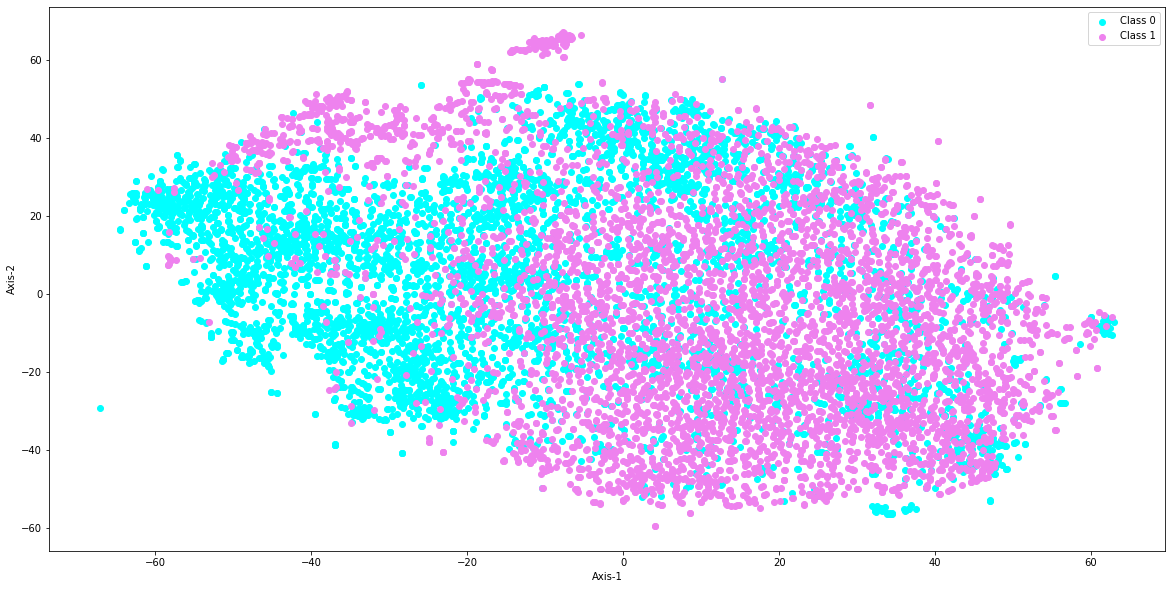

In [131]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
plt.figure(figsize=(20,10))
pca = PCA(0.95)
pca = pca.fit_transform(train_X)
tsne =TSNE(n_components=2)
tsne = tsne.fit_transform(pca)
colors = ['cyan','violet']
for i in range(len(colors)):
    data = tsne[train_Y==i]
    plt.scatter(data[:,0],data[:,1],label="Class "+str(i),c=colors[i])
plt.xlabel("Axis-1")
plt.ylabel("Axis-2")
plt.legend()
plt.show()

In [114]:
unique_elements, counts_elements = np.unique(train_Y, return_counts=True)
print("CLASS DISTRIBUTION OF TRAINING DATA")
for i in range(len(unique_elements)):
  print("count of class ",unique_elements[i],":=  ", counts_elements[i])

CLASS DISTRIBUTION OF TRAINING DATA
count of class  0 :=   5000
count of class  1 :=   5000


In [115]:
unique_elements, counts_elements = np.unique(test_Y, return_counts=True)
print("CLASS DISTRIBUTION OF TESTING DATA")
for i in range(len(unique_elements)):
  print("count of class ",unique_elements[i],":=  ", counts_elements[i])

CLASS DISTRIBUTION OF TESTING DATA
count of class  0 :=   1000
count of class  1 :=   1000


In [117]:
train_X = train_X.reshape(-1,3,32,32).transpose(0,2,3,1)
train_X.shape

(10000, 32, 32, 3)

In [118]:
test_X = test_X.reshape(-1,3,32,32).transpose(0,2,3,1)
test_X.shape

(2000, 32, 32, 3)

5 Train Images


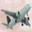

0


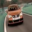

1


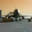

0


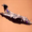

0


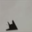

0
5 Test Images


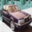

1


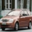

1


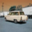

1


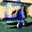

0


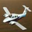

0


In [122]:
from google.colab.patches import cv2_imshow
import random
print("5 Train Images")
for i in range(5):
  im = random.randint(0,train_X.shape[0]-1)
  cv2_imshow(train_X[i])
  print(train_Y[i])
print("5 Test Images")
for i in range(5):
  im= random.randint(0,test_X.shape[0]-1)
  cv2_imshow(test_X[i])
  print(test_Y[i])

In [98]:
ALEX_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
if torch.cuda.is_available():
  ALEX_model = ALEX_model.to('cuda')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [99]:
preprocess = transforms.Compose([transforms.Resize((227,227)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

In [100]:
from PIL import Image as im
array_of_nps = []
for i in range(train_X.shape[0]):
  image = im.fromarray(train_X[i])
  im_processed = preprocess(image)
  im_processed = im_processed.unsqueeze(0)
  if torch.cuda.is_available():
    im_processed = im_processed.to('cuda')
  op = ALEX_model(im_processed)[0]
  #print(op)
  im_ans = op.to('cpu')
  im_ans = im_ans.detach()
  im_ans = im_ans.numpy().tolist()
  array_of_nps.append(im_ans)
data_frame = pd.DataFrame.from_records(array_of_nps)
data_frame[1000] = train_Y
data_frame.to_csv("INPUT_FOR_PYTORCH_TRAIN.csv",index= False)

In [101]:
array_of_nps = []
for i in range(test_X.shape[0]):
  image = im.fromarray(test_X[i])
  im_processed = preprocess(image)
  im_processed = im_processed.unsqueeze(0)
  if torch.cuda.is_available():
    im_processed = im_processed.to('cuda')
  op = ALEX_model(im_processed)[0]
  #print(op)
  im_ans = op.to('cpu')
  im_ans = im_ans.detach()
  im_ans = im_ans.numpy().tolist()
  array_of_nps.append(im_ans)

data_frame = pd.DataFrame.from_records(array_of_nps)
data_frame[1000] = test_Y

data_frame.to_csv("INPUT_FOR_PYTORCH_TEST.csv",index= False)

In [102]:
train = pd.read_csv("INPUT_FOR_PYTORCH_TRAIN.csv")
test = pd.read_csv("INPUT_FOR_PYTORCH_TEST.csv")
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000
0,5.002892,-1.872501,-1.182479,0.389502,-0.088339,-0.098670,-6.362573,-4.330982,-7.486349,-2.636074,-1.119356,-5.835654,-5.502632,-7.137283,-2.689414,-6.159851,-5.027721,-1.774079,-4.324801,-5.810260,-4.247669,-1.125834,-6.816483,-3.470388,-4.106684,0.951043,-0.203634,-0.083805,3.856311,3.152163,-3.106779,-1.499647,1.674509,2.597712,1.877302,-2.779864,-0.551846,-6.002664,3.910276,-2.984858,...,-5.248625,-0.686741,-8.222886,-2.273317,-5.806883,-5.673706,-6.231895,-3.846618,-0.391980,3.325001,-1.905574,-1.572683,2.449300,-0.605307,5.609385,5.635457,6.033514,3.777473,3.046527,0.616162,1.724338,-3.415817,-1.319348,-5.250410,-3.338621,-6.318724,-1.508918,-3.843772,-7.589837,-4.879281,-5.292785,-4.947451,-4.962897,-3.109006,-2.225135,-1.528645,-4.676342,-1.300643,-3.503703,1
1,-2.544838,2.079777,-3.364653,-4.946920,-4.545716,-1.629918,-6.831150,-0.882671,-4.168384,-3.631339,0.846605,-5.831659,-2.358713,-3.878418,-2.889227,-2.656392,-2.348002,-4.444337,-5.210628,-4.949564,-5.682162,-5.816956,-7.394293,-4.105666,-3.897365,-2.218795,1.598102,2.948717,2.445218,-1.317285,-3.432522,-2.811073,2.553243,-2.006577,0.409405,-1.872995,0.676890,-2.812220,0.451240,-2.919568,...,-3.641217,2.630870,-2.288985,-1.532549,-2.722371,-0.312411,-1.446826,1.338914,5.115135,-2.336860,-1.949796,-3.976906,-0.559059,-4.051940,-1.240391,-2.582528,-0.028334,-2.028275,-3.121402,-2.013002,1.323627,-5.454152,-4.916243,-7.509178,-2.352996,-6.397224,0.085625,-3.478365,1.319454,-0.393807,-2.238426,1.607025,0.389355,1.567334,2.506573,1.645717,-1.242066,-1.079093,-2.727013,1
2,0.669248,-0.490701,-1.486384,-2.259361,0.496323,1.967446,-6.717308,-0.956876,-3.455268,-5.355587,1.208992,-2.477318,-3.739072,-3.372703,-2.697515,-2.726957,0.476396,-1.433876,-0.309146,-2.992245,-0.717142,1.633196,-2.013698,-2.170653,-3.412469,0.730802,-1.959402,-3.248720,3.238592,2.062382,-3.801123,-2.030195,-0.139319,-0.195990,-0.216023,-2.598263,-1.027567,-5.097321,0.756381,-3.054615,...,-5.161812,-1.991629,-7.090364,-2.166916,-4.863976,-0.809686,-3.042848,0.890164,3.037560,-1.942517,-1.281897,-3.115275,-2.923537,0.206451,0.341090,-0.630948,-1.051786,-2.467061,-1.574696,-0.828245,-0.329282,-3.539357,-2.016620,-5.163913,2.527234,-4.004203,-0.256456,0.116549,-1.488555,-0.373624,-3.795451,-3.962835,-3.835001,-2.485681,1.938032,-0.950907,-4.990942,1.128199,-0.911727,0
3,-1.148712,2.093115,-2.748914,-2.067158,0.677288,2.086346,-3.481748,-0.655490,-1.987660,-3.341171,1.804974,0.076632,-0.357488,-2.578997,-0.610014,-3.078158,0.774063,1.662121,-2.512982,-1.685766,-2.536507,0.412917,-6.827555,-2.739393,-3.222331,-4.423528,0.473493,-0.612246,-1.778414,-0.126151,-3.569417,-0.347480,-0.144108,-2.677619,0.159080,-4.996609,1.861794,-6.270387,2.764430,-2.535887,...,-3.622531,-2.820759,-3.892272,-1.907495,-1.572674,-2.343520,-2.672288,-0.799789,2.400859,-0.264399,0.241190,-1.885371,-1.304300,-2.931679,0.220678,-1.359731,0.330467,0.873517,-1.879090,-2.838013,4.173178,-4.550633,-2.549944,-4.232144,1.874765,-3.265419,-1.367779,-1.054725,4.791069,-3.307983,-4.565407,0.684877,-5.040142,-3.025267,0.871759,-0.606350,-3.937660,0.197954,-0.886118,0
4,0.942884,-3.211229,-3.060831,-3.081681,-0.837968,0.735851,-6.831043,-4.183236,-5.634107,-5.008485,1.430423,-4.360115,-4.290029,-3.752093,-2.156261,-4.526808,-4.953527,-3.423166,-5.678285,-3.768964,-4.806915,-3.883934,-7.387432,-4.962435,-4.270809,-1.446705,0.428980,-2.861824,2.339760,2.653029,-2.020768,-1.415345,1.818875,-2.513429,-0.923089,-3.041944,-0.368415,-6.842837,0.932821,-3.658605,...,-5.067592,-3.105098,-5.017784,-6.312801,-6.570240,-3.430175,-4.012075,-1.801423,1.623912,2.175709,-0.329183,-0.974344,-2.402933,-0.682311,4.707755,1.869387,3.253023,2.880793,1.394298,-2.314234,1.664344,-1.248811,-

In [103]:
if torch.cuda.is_available():  
  train_X = torch.from_numpy(train[train.columns[:-1]].to_numpy().astype('float32')).to('cuda')
  train_Y = torch.from_numpy(train[train.columns[-1:]].to_numpy()).to('cuda')
  test_X = torch.from_numpy(test[test.columns[:-1]].to_numpy().astype('float32')).to('cuda')
  test_Y = torch.from_numpy(test[test.columns[-1:]].to_numpy()).to('cuda')
train_Y.T[0]

tensor([1, 1, 0,  ..., 0, 1, 1], device='cuda:0')

In [104]:
class Nueral_Net(NN.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = NN.Linear(1000, 512)
        self.layer_2 = NN.Linear(512,256)
        self.layer_3 = NN.Linear(256, 2)
    def forward(self, x):
        x = funct.relu(self.layer_1(x))
        x = funct.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x
nn_torch = Nueral_Net()
nn_torch.to('cuda')
print(nn_torch)

Nueral_Net(
  (layer_1): Linear(in_features=1000, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=2, bias=True)
)


In [105]:
loss_function = NN.CrossEntropyLoss()
optimizer = optim.Adam(nn_torch.parameters(), lr=0.01)
epocs =100

loss_function.to('cuda')


CrossEntropyLoss()

tensor(0.7448, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(3.3668, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(148.8425, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(31.6741, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(5.0576, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9065, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6668, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5768, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5999, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6543, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3071, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(6.9912, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2245, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2747, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2773, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2590, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2418, device='cuda:0', grad_fn=<NllLossBackw

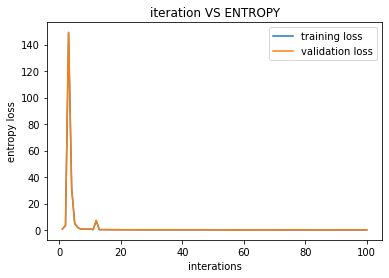

In [106]:
train_loss = []
val_loss =[]
iters =[]
for i in range(epocs): 
    iters.append(i+1)
    X = train_X
    y= train_Y 
    nn_torch.zero_grad() 
    output = nn_torch(X)
    val_output = nn_torch(test_X)
    loss = loss_function(output, y.T[0]) 
    loss_val = loss_function(val_output,test_Y.T[0])
    with torch.no_grad():
      train_loss.append(loss.detach())
      val_loss.append(loss_val.detach())
    loss.backward() 
    optimizer.step()
    print(loss)
print("training loss :  ", train_loss[-1])
print("test loss :  ", val_loss[-1])

plt.title('iteration VS ENTROPY')
plt.plot(iters,train_loss,label = 'training loss')
plt.plot(iters,val_loss, label = 'validation loss')
plt.xlabel('interations')
plt.ylabel('entropy loss')
plt.legend()
plt.show()

In [107]:
with torch.no_grad():
  ypred = nn_torch(train_X)
  Y_test = train_Y.T[0]
  pred =ypred.argmax(1)
  count=0
  for i in range(len(ypred)):
    if (pred[i]==Y_test[i]):
      count+=1
  print("training accuracy  ",count/len(ypred)*100)

training accuracy   97.18


In [108]:
with torch.no_grad():
  ypred = nn_torch(test_X)
  Y_test = test_Y.T[0]
  pred =ypred.argmax(1)
  count=0
  for i in range(len(ypred)):
    if (pred[i]==Y_test[i]):
      count+=1
  print("testing accuracy  ",count/len(ypred)*100)

testing accuracy   95.15


Text(0.5, 15.0, 'predicted values')

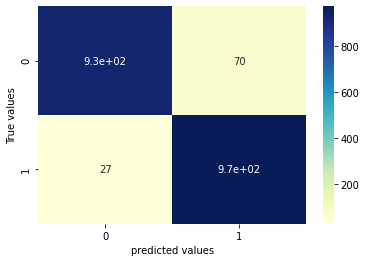

In [109]:
from sklearn.metrics import confusion_matrix,roc_curve,auc
import seaborn as sns
c = confusion_matrix(Y_test.cpu(),pred.cpu())
sns.heatmap(c,annot = True,cmap="YlGnBu")

plt.ylabel('True values')
plt.xlabel('predicted values')


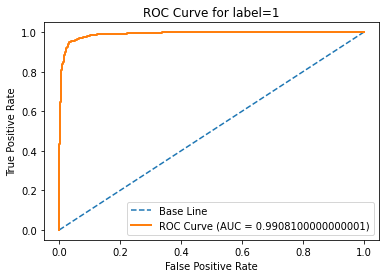

In [110]:
fpr, tpr, thresholds = roc_curve(Y_test.cpu(), ypred.cpu().numpy()[:,1], pos_label=1)
plt.plot([0, 1], [0, 1], linestyle='--', label='Base Line')
plt.plot(fpr, tpr, linewidth=2, label='ROC Curve (AUC = '+str(auc(fpr, tpr))+')')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for label=1')
plt.legend(loc="lower right")

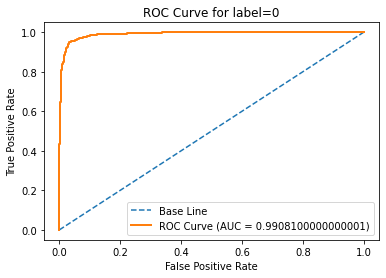

In [111]:
fpr, tpr, thresholds = roc_curve(Y_test.cpu(), ypred.cpu().numpy()[:,1], pos_label=0)
plt.plot([0, 1], [0, 1], linestyle='--', label='Base Line')
plt.plot(tpr, fpr, linewidth=2, label='ROC Curve (AUC = '+str(auc(tpr, fpr))+')')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for label=0')
plt.legend(loc="lower right")

In [133]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import math
import pickle
from scipy.special import softmax
from sklearn.model_selection import train_test_split



class MyNeuralNetwork():
    """
    My implementation of a Neural Network Classifier.
    """
    

    def __init__(self, n_layers, layer_sizes, activation, learning_rate, weight_init, batch_size, num_epochs):
        """
        Initializing a new MyNeuralNetwork object

        Parameters
        ----------
        n_layers : int value specifying the number of layers

        layer_sizes : integer array of size n_layers specifying the number of nodes in each layer

        activation : string specifying the activation function to be used
                     possible inputs: relu, sigmoid, linear, tanh

        learning_rate : float value specifying the learning rate to be used

        weight_init : string specifying the weight initialization function to be used
                      possible inputs: zero, random, normal

        batch_size : int value specifying the batch size to be used

        num_epochs : int value specifying the number of epochs to be used
        """
        self.n_layers = 0
        self.layer_sizes = []
        self.activation = 'relu'
        self.learning_rate = 0.01
        self.weight_init = 'random'
        self.batch_size = 100
        self.num_epochs = 10
        self.acti_fns = ['relu', 'sigmoid', 'linear', 'tanh', 'softmax']
        self.weight_inits = ['zero', 'random', 'normal']
        self.W = []
        self.B = []
        self.losses_train= []
        self.accuracies_train = []
        self.losses_test= []
        self.accuracies_test = []
        self.fun = None
        self.fun_grad = None
        if activation not in self.acti_fns:
            raise Exception('Incorrect Activation Function')

        if weight_init not in self.weight_inits:
            raise Exception('Incorrect Weight Initialization Function')
        self.n_layers = n_layers
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weight_init = weight_init
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.activation = activation

        if (n_layers != len(layer_sizes)):
            raise Exception('Wrong parameters layers and their sizes')


    def RELU(self, a):
        return max(0.0, a)

    def RELU_diff(self, a):
        if a > 0:
            return 1.0
        else:
            return 0.0

    def relu(self, X):
        """
        Calculating the ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        # f = np.vectorize(self.RELU)
        # return f(X)
        return (X>0)*X

    def relu_grad(self, X):
        """
        Calculating the gradient of ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        # f = np.vectorize(self.RELU_diff)
        # return f(X)
        return (X>0)*1

    def sig(self, a):
        return 1/(1+math.exp(-1*a))

    def sig_diff(self, a):
        return self.sig(a)*(1-self.sig(a))

    def sigmoid(self, X):
        """
        Calculating the Sigmoid activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        # f = np.vectorize(self.sig)
        # return f(X)
        return 1.0 / (1+np.exp(-X))

    def sigmoid_grad(self, X):
        """
        Calculating the gradient of Sigmoid activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        # f = np.vectorize(self.sig_diff)
        # return f(X)

        sigma = self.sigmoid(X)
        return sigma*(1-sigma)

    def linear(self, X):
        """
        Calculating the Linear activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        X = np.clip(X,-1000,1000)
        return X

    def linear_grad(self, X):
        """
        Calculating the gradient of Linear activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        return np.ones((X.shape[0],X.shape[1]))

    def tan(self, a):
        return (math.exp(a)-math.exp(-1*a))/(math.exp(a)+math.exp(-1*a))

    def tan_diff(self, a):
        return 1 - (self.tan(a))**2

    def tanh(self, X):
        """
        Calculating the Tanh activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        return np.tanh(X)

    def tanh_grad(self, X):
        """
        Calculating the gradient of Tanh activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        return 1- (self.tanh(X))**2

    def softmax(self, X):
        """
        Calculating the ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        if (self.activation == 'linear'):
        	X = np.clip(X,-1000,1000)
        exps = np.exp(X-X.max())
        return exps / np.sum(exps,axis=1)[:,None]

    def softmax_grad(self, X):
        """
        Calculating the gradient of Softmax activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        return None

    def zero_init(self, shape):
        """
        Calculating the initial weights after Zero Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated

        Returns
        -------
        weight : 1-dimensional numpy array which contains the initial weights for the requested layer
        """
        return np.zeroes(shape)

    def random_init(self, shape):
        """
        Calculating the initial weights after Random Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated

        Returns
        -------
        weight : 1-dimensional numpy array which contains the initial weights for the requested layer
        """
        return np.random.rand(shape[0],shape[1]) * 0.01

    def normal_init(self, shape):
        """
        Calculating the initial weights after Normal(0,1) Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated

        Returns
        -------
        weight : 1-dimensional numpy array which contains the initial weights for the requested layer
        """
        return np.random.normal(scale=1,size=(shape[0],shape[1])) * 0.01

    def fit(self, X, y,test_X =[],test_Y= []):
        """
        Fitting (training) the linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

        y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels.

        Returns
        -------
        self : an instance of self
        """

        # fit function has to return an instance of itself or else it won't work with test.py
        # train_X,test_X,train_Y,test_Y = train_test_split(X, y, test_size=0.2, stratify=y)
        if self.weight_init == 'normal':
            for i in range(self.n_layers-1):
                self.W.append(self.normal_init((self.layer_sizes[i], self.layer_sizes[i+1])))
                self.B.append(self.normal_init((1,self.layer_sizes[i+1])))
        elif self.weight_init == 'random':
            for i in range(self.n_layers-1):
                self.W.append(self.random_init((self.layer_sizes[i], self.layer_sizes[i+1])))
                self.B.append(self.random_init((1,self.layer_sizes[i+1])))
        elif self.weight_init == 'zero':
            for i in range(self.n_layers-1):
                self.W.append(self.zero_init((self.layer_sizes[i], self.layer_sizes[i+1])))
                self.B.append(self.zero_init((1,self.layer_sizes[i+1])))

        if self.activation == 'relu':
            self.fun = self.relu
            self.fun_grad = self.relu_grad  
        if self.activation == 'sigmoid':
            self.fun = self.sigmoid
            self.fun_grad = self.sigmoid_grad
        if self.activation == 'tanh':
            self.fun = self.tanh
            self.fun_grad = self.tanh_grad
        if self.activation == 'linear':
            self.fun = self.linear
            self.fun_grad = self.linear_grad
        if self.activation == 'softmax':
            self.fun = self.softmax
            self.fun_grad = self.softmax_grad
        for i in range(self.num_epochs):
            print(i)
            for j in range(max(len(train_X)//self.batch_size,1)):
                print(j)
                z, a = self.forward_propogation(train_X[j*self.batch_size:(j+1)*self.batch_size],self.fun)
                self.backward_propogation(z, a, train_X[j*self.batch_size:(j+1)*self.batch_size], train_Y[j*self.batch_size:(j+1)*self.batch_size],self.fun_grad)
            self.accuracies_train.append(self.score(train_X, train_Y))
            self.losses_train.append(self.log_loss(train_X,train_Y))
            self.accuracies_test.append(self.score(test_X, test_Y))
            self.losses_test.append(self.log_loss(test_X,test_Y))

            print(self.accuracies_train)
            print(self.accuracies_test)
            print(self.losses_train)
            print(self.losses_test)
        return self

    def predict_proba(self, X):
        """
        Predicting probabilities using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        Returns
        -------
        y : 2-dimensional numpy array of shape (n_samples, n_classes) which contains the 
            class wise prediction probabilities.
        """

        # return the numpy array y which contains the predicted values
        z,a = self.forward_propogation(X,self.fun)
        return a[-1]

    def predict(self, X):
        """
        Predicting values using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        Returns
        -------
        y : 1-dimensional numpy array of shape (n_samples,) which contains the predicted values.
        """

        # return the numpy array y which contains the predicted values
        z, a = self.forward_propogation(X,self.fun)
        prediction = np.argmax(a[-1],axis=1)
        return prediction

    def log_loss(self,X,y):
        loss = 0
        z, a = self.forward_propogation(X,self.fun)
        print(a[-1])

        loss = -1*np.sum(np.multiply(np.log(a[-1]+10**(-10)),y) + np.multiply(np.log(1-a[-1]+10**(-10)),1-y),axis=1)
        return np.mean(loss)

    def score(self, X, y):
        """
        Predicting values using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        y : 1-dimensional numpy array of shape (n_samples,) which acts as testing labels.

        Returns
        -------
        acc : float value specifying the accuracy of the model on the provided testing set
        """

        # return the numpy array y which contains the predicted values
        prediction = self.predict(X)
        # print(y)
        count = 0
        print(prediction,prediction.shape)
        for i in range(len(prediction)):
            if y[i][prediction[i]]==1:
                count += 1
        return count/len(prediction)*100

    def forward_propogation(self, train_X, func):
        Z = []
        A = []
        for i in range(0, self.n_layers-1):
            if i == 0:
                Z.append(np.dot(train_X,self.W[i])+self.B[i])
                A.append(func(Z[-1]))
            elif i != self.n_layers-2:
                Z.append(np.dot(A[i-1],self.W[i])+self.B[i])
                A.append(func(Z[-1]))
            else:
                Z.append(np.dot(A[i-1],self.W[i])+self.B[i])
                A.append(self.softmax(Z[-1]))
                # print(Z[-1])
                # print(A[-1])
                # print(np.sum(A[-1],axis=1))

        return Z, A

    def backward_propogation(self, Z, A, train_X, train_Y ,func_grad):
        n = len(train_Y)
        Grad_W = []
        Grad_B = []
        for i in range(self.n_layers-2, -1, -1):
            if (i == self.n_layers-2):
                dZ2 = A[i]-train_Y
                Grad_W.insert(0, np.dot(A[i-1].T,dZ2)/n)
                Grad_B.insert(0, np.sum(dZ2, axis=0)/n)
            elif (i != 0):
                dZ = np.multiply(np.dot(dZ2,self.W[i+1].T), func_grad(Z[i]))
                Grad_W.insert(0, np.dot(A[i-1].T,dZ)/n)
                Grad_B.insert(0, np.sum(dZ, axis=0)/n)
                dZ2 = dZ
            else:
                dZ = np.multiply(np.dot(dZ2,self.W[i+1].T), func_grad(Z[i]))
                Grad_W.insert(0, np.dot(train_X.T,dZ)/n)
                Grad_B.insert(0, np.sum(dZ, axis=0)/n)
        for i in range(0, self.n_layers-1):
            self.W[i] = self.W[i]-self.learning_rate*Grad_W[i]
            self.B[i] = self.B[i]-self.learning_rate*Grad_B[i]
    def print_loss_and_acc(self):
    	print("model = ",self.activation)
    	print("test_loss = ",self.losses_test[-1])
    	print("test_accuracy = ",self.accuracies_test[-1])


if __name__ == '__main__':
    mnist = fetch_openml('mnist_784')
    x = mnist.data
    y = mnist.target
    x = x.astype(dtype='int32')
    y = y.astype(dtype='int32')
    hot_y = np.zeros((y.shape[0],10))
    hot_y[np.arange(y.shape[0]),y]=1
    train_X,test_X,train_Y,test_Y = train_test_split(x, hot_y, test_size=0.2, stratify=hot_y)


    model = MyNeuralNetwork(
         5, [784, 256, 128, 64, 10], 'relu', 0.1, 'normal', 7000, 100)
    model = model.fit(train_X, train_Y,test_X,test_Y)
    print(model.predict(test_X))
    print(model.score(test_X,test_Y))

    f = "model_relu"

    pickle.dump(model,open(f,'wb'))

    model_2 = MyNeuralNetwork(
         5, [784, 256, 128, 64, 10], 'tanh', 0.1, 'normal', 7000, 100)
    model_2 = model_2.fit(train_X, train_Y,test_X,test_Y)
    print(model_2.predict(test_X))
    print(model_2.score(test_X,test_Y))

    f = "model_tanh"

    pickle.dump(model_2,open(f,'wb'))

    model_3 = MyNeuralNetwork(
         5, [784, 256, 128, 64, 10], 'sigmoid', 0.1, 'normal', 700, 100)
    model_3 = model_3.fit(train_X, train_Y,test_X,test_Y)
    print(model_3.predict(test_X))
    print(model_3.score(test_X,test_Y))

    f = "model_sigmoid"

    pickle.dump(model_3,open(f,'wb'))

    model_4 = MyNeuralNetwork(
         5, [784, 256, 128, 64, 10], 'linear', 0.1, 'normal', 7000, 100)
    model_4 = model_4.fit(train_X, train_Y,test_X,test_Y)
    print(model_4.predict(test_X))
    print(model_4.score(test_X,test_Y))

    f = "model_linear"

    pickle.dump(model_4,open(f,'wb'))



    # model_3 = MyNeuralNetwork(
    #     5, [784, 256, 128, 64, 10], 'sigmoid', 0.1, 'normal', 700, 100)
    # model_3.fit(train_X, train_Y)
    # model_3.predict(test_X,test_Y)
    # model_3.score(test_X,test_Y)

    # # f = "model_tanh.sav"
    # # pickle.dump(model_2,open(f,'wb'))

    # # c = pickle.load(open(f,'rb'))
    # # c.print_loss_and_acc()

    # # model_3 = MyNeuralNetwork(
    # #     5, [784, 256, 128, 64, 10], 'sigmoid', 0.1, 'normal', 700, 100)
    # # model_3.fit(x, hot_y)
    # # f = "model_sigmoid.sav"
    # # pickle.dump(model_3,open(f,'wb'))

    # # c = pickle.load(open(f,'rb'))
    # # c.print_loss_and_acc()

    # model_4 = MyNeuralNetwork(
    #     5, [784, 256, 128, 64, 10], 'linear', 0.1, 'normal', 7000, 100)
    # model_4.fit(x, hot_y)
    # f = "model_linear.sav"
    # pickle.dump(model_4,open(f,'wb'))

    c = pickle.load(open("model_relu",'rb'))
    c.print_loss_and_acc()
    

0
0
1
2
3
4
5
6
7
[0 0 3 ... 0 3 0] (56000,)
[[0.1205226  0.08560716 0.11806993 ... 0.08678177 0.1114338  0.09103727]
 [0.12882962 0.07846297 0.11202629 ... 0.09163007 0.10390817 0.09677884]
 [0.10219238 0.09423654 0.10643395 ... 0.0914618  0.10722328 0.09958255]
 ...
 [0.19330546 0.06789156 0.11177539 ... 0.09479662 0.09353174 0.08826144]
 [0.0996376  0.09750527 0.10655742 ... 0.09243942 0.10633634 0.09461752]
 [0.16197172 0.06550457 0.12339653 ... 0.08637333 0.10591201 0.08839395]]
[3 0 3 ... 2 0 0] (14000,)
[[0.10335939 0.09315256 0.10798785 ... 0.09533088 0.10610088 0.09914082]
 [0.12202665 0.08328468 0.11248457 ... 0.08962879 0.10866644 0.09208238]
 [0.10068866 0.09522884 0.1081941  ... 0.09559788 0.10701298 0.09847632]
 ...
 [0.11678042 0.0850919  0.11706955 ... 0.09337173 0.10634911 0.09039136]
 [0.18941632 0.06401312 0.1183462  ... 0.08676966 0.10015172 0.08677466]
 [0.14109234 0.0751896  0.12337022 ... 0.08702415 0.11105572 0.08322879]]
[22.8875]
[23.22142857142857]
[3.1303374

KeyboardInterrupt: ignored